In [1]:
import pyreadr
import scanpy as sc
import numpy as np
import os
import pandas as pd
import anndata as ad
import scrublet as scr
from pathlib import Path

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

In [2]:
# where to save the file and filename to give
DIR2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/scrublet_qc/")
DIR2SAVE.mkdir(parents=True, exist_ok=True)

scrublet_filename = "Che2021_CRC_LM_scrublet.txt"

# figures path to save
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [3]:
adata = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/raw/Che2021_CRC_LM_raw.h5ad"
)

In [4]:
set(adata.obs.Tissue)

{'LM'}

In [5]:
len(set(adata.obs.Patient))

6

In [6]:
adata.obs[["Therapy", "Patient"]].drop_duplicates(
    subset=["Therapy", "Patient"], inplace=False
).groupby("Therapy").size()

Therapy
NAC      3
naive    3
dtype: int64

### run scrublet per sample and on raw data
* When working with data from multiple samples, run Scrublet on each sample separately. Because Scrublet is designed to detect technical doublets formed by the random co-encapsulation of two cells, it may perform poorly on merged datasets where the cell type proportions are not representative of any single sample.

In [7]:
adata.obs

,Patient,Tissue,Therapy,Cell_type,Cell_subtype,Sample
AAACCTGAGAGTACAT_COL07_LM,COL07,LM,naive,cDC1/migDC,cDC1,COL07_LM
AAACCTGAGAGTGACC_COL07_LM,COL07,LM,naive,pDC,pDC,COL07_LM
AAACCTGAGGCTAGAC_COL07_LM,COL07,LM,naive,T/NK/ILC,MKI67 T,COL07_LM
AAACCTGAGTGCCAGA_COL07_LM,COL07,LM,naive,Myeloid,TAM SPP1,COL07_LM
AAACCTGAGTGGTAGC_COL07_LM,COL07,LM,naive,T/NK/ILC,Naive CD4 T,COL07_LM
...,...,...,...,...,...,...
TTTGTCATCGGTCTAA_COL18_LM,COL18,LM,NAC,B,B,COL18_LM
TTTGTCATCTCGCATC_COL18_LM,COL18,LM,NAC,Myeloid,Myeloid/T doublet,COL18_LM
TTTGTCATCTCGGACG_COL18_LM,COL18,LM,NAC,T/NK/ILC,NK2,COL18_LM
TTTGTCATCTGTGCAA_COL18_LM,COL18,LM,NAC,T/NK/ILC,Naive CD4 T,COL18_LM


#### Check that the data is raw 

In [8]:
adata.X.todense()[1:5, 1:5]

matrix([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=float32)

In [9]:
np.max(adata.X)

23832.0

#### run scrublet
scr.scrub_doublets() simulates doublets from the observed data and uses a k-nearest-neighbor classifier to calculate a continuous doublet_score (between 0 and 1) for each transcriptome. The score is automatically thresholded to generate predicted_doublets, a boolean array that is True for predicted doublets and False otherwise.

In [10]:
def run_scrublet(adata, sample_col="Sample", cellbarcode_index_name="level_1"):
    # create dict that stores scrublet results from each sample in adata
    scrublet_dict = {k: None for k in list(set(adata.obs[sample_col]))}

    # run scrublet per sample
    for sample in scrublet_dict.keys():
        print("Sample:", sample)
        adata_tmp = adata[adata.obs[sample_col] == sample].copy()
        scrub = scr.Scrublet(adata_tmp.X)
        (
            adata_tmp.obs["doublet_score"],
            adata_tmp.obs["predicted_doublet"],
        ) = scrub.scrub_doublets()
        # scrub.plot_histogram()
        # sc.external.pp.scrublet(adata_tmp)
        scrublet_dict[sample] = adata_tmp.obs[
            ["Sample", "doublet_score", "predicted_doublet"]
        ]
        # sc.external.pl.scrublet_score_distribution(adata_tmp)

    # Put all scores in a single panda dataframe
    scrublet_concat = (
        pd.concat(scrublet_dict, axis=0)
        .reset_index()
        .drop(labels="level_0", axis=1)
        .set_index(cellbarcode_index_name)
    )

    return scrublet_concat

In [11]:
scrublet_concat = run_scrublet(
    adata, sample_col="Sample", cellbarcode_index_name="level_1"
)

Sample: COL18_LM
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.0%
Elapsed time: 6.9 seconds
Sample: COL17_LM
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.72
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 66.7%
Elapsed time: 6.0 seconds
Sample: COL07_LM
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor sear

In [12]:
scrublet_concat

,Sample,doublet_score,predicted_doublet
level_1,,,
AAACCTGAGACCGGAT_COL18_LM,COL18_LM,0.261719,False
AAACCTGAGCTGAACG_COL18_LM,COL18_LM,0.181818,False
AAACCTGAGGCAGGTT_COL18_LM,COL18_LM,0.113208,False
AAACCTGAGGGCTTGA_COL18_LM,COL18_LM,0.146067,False
AAACCTGCAAGGTTCT_COL18_LM,COL18_LM,0.150510,False
...,...,...,...
TTTGTCAGTTCTGGTA_COL15_LM,COL15_LM,0.111111,False
TTTGTCATCATGTGGT_COL15_LM,COL15_LM,0.207746,False
TTTGTCATCGAATCCA_COL15_LM,COL15_LM,0.093656,False


In [13]:
print(
    "Number of predicted doublets: ",
    scrublet_concat[scrublet_concat["predicted_doublet"] == True].shape[0],
)

Number of predicted doublets:  224


In [14]:
scrublet_concat.to_csv(
    DIR2SAVE.joinpath(scrublet_filename), sep="\t", index=True, header=True
)

In [15]:
## add scores to adata.obs
# add annot to .obs
adata.obs = adata.obs.merge(
    right=scrublet_concat[["doublet_score"]],
    how="left",
    right_index=True,
    left_index=True,
)

### Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

In [16]:
# find genes that are mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# find genes that are ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

# compute QC metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=False, percent_top=None
)

In [17]:
print(
    adata.obs[
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]
    ].describe()
)

print(adata.var[["n_cells_by_counts", "total_counts"]].describe())

       n_genes_by_counts  total_counts  pct_counts_mt  pct_counts_ribo
count       54219.000000  54219.000000   54219.000000     54219.000000
mean         1084.729634   3680.830322       6.171463        25.939625
std           634.626240   3981.856689      12.674388         9.324035
min            31.000000    543.000000       0.000000         0.424628
25%           705.000000   1784.000000       1.843761        20.147541
50%           881.000000   2380.000000       2.607362        26.516193
75%          1253.000000   3774.000000       3.797658        32.206657
max          6770.000000  73441.000000      98.623535        78.410957
       n_cells_by_counts  total_counts
count       33694.000000  3.369400e+04
mean         1745.502345  5.923041e+03
std          5176.119117  8.165955e+04
min             0.000000  0.000000e+00
25%             0.000000  0.000000e+00
50%            34.000000  3.600000e+01
75%          1076.000000  1.196000e+03
max         54108.000000  1.009806e+07


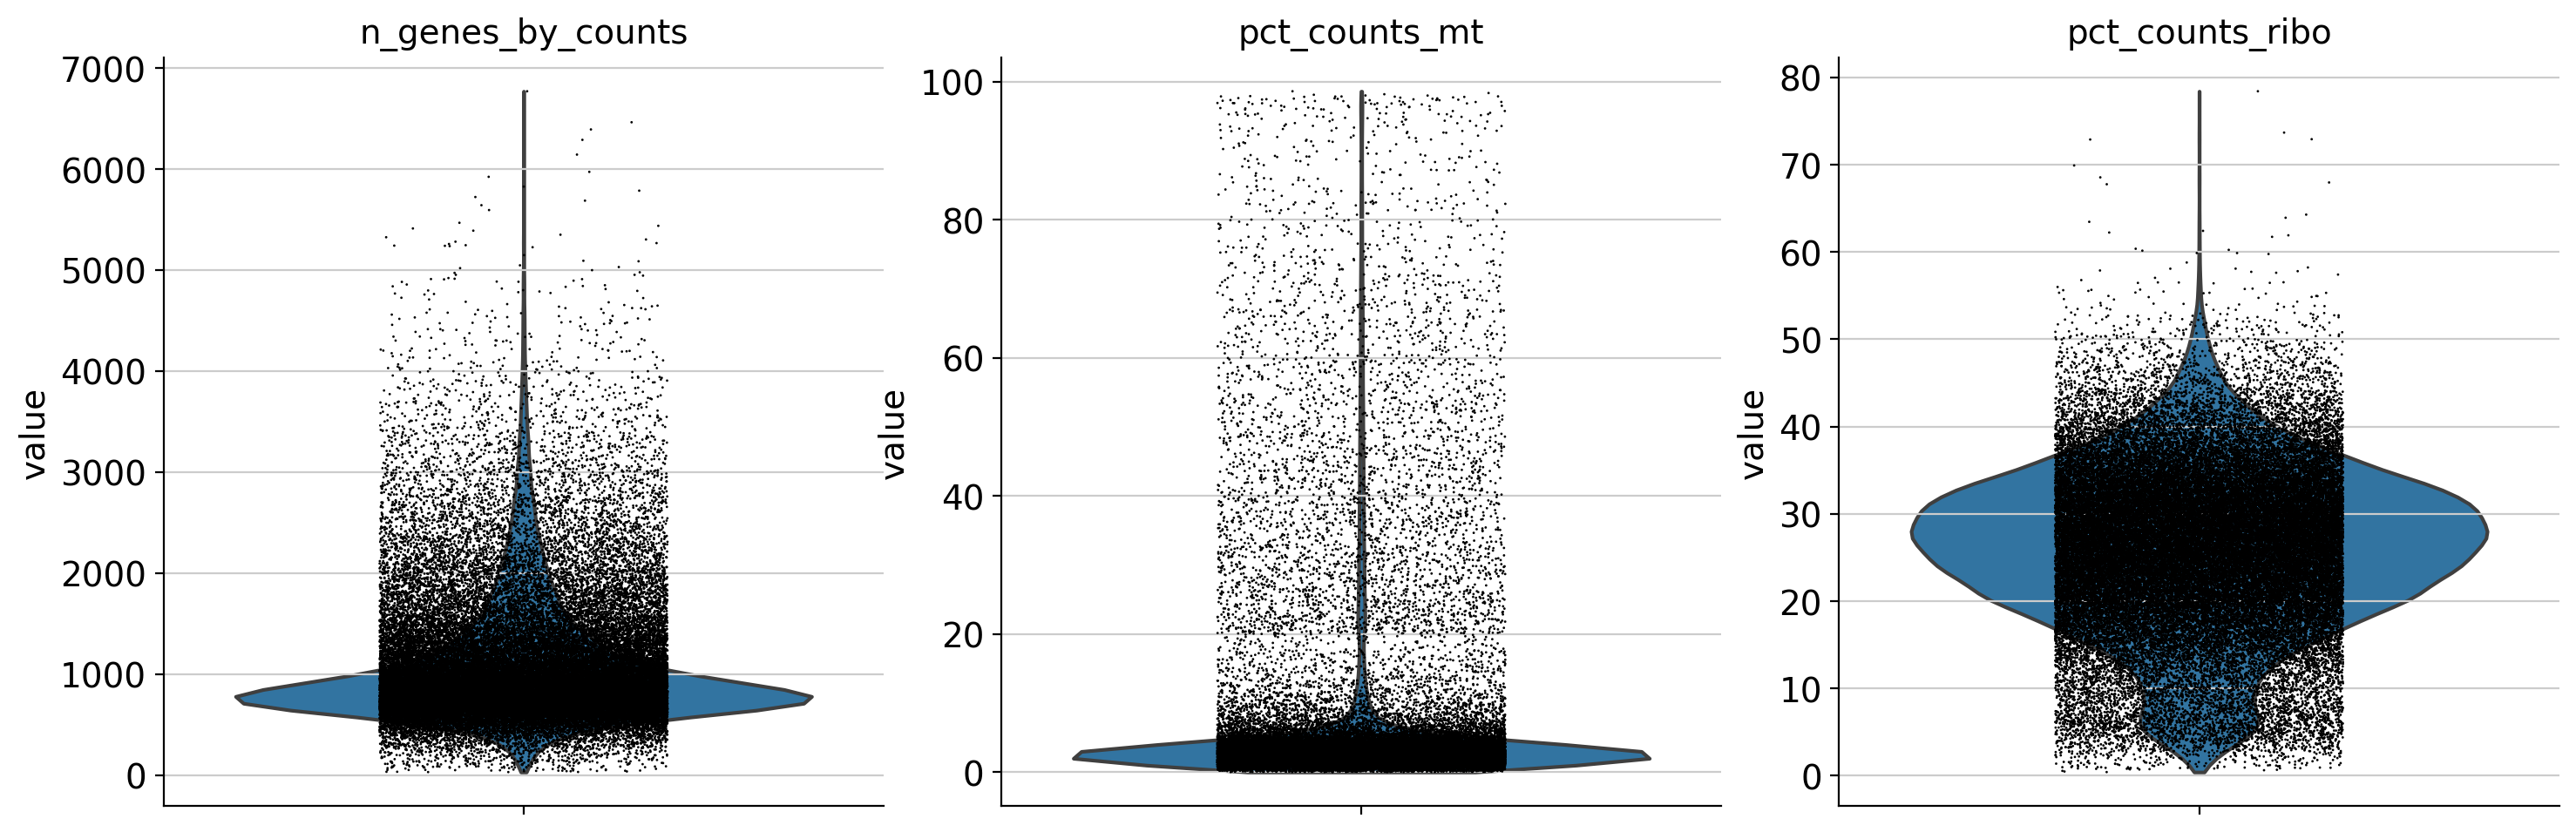

In [18]:
# violin plot of some distributions
sc.pl.violin(
    adata,
    keys=["n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.2,
    multi_panel=True,
    rotation=30,
    save="Che2021_CRC_QC_covariates.pdf",
    show=True,
)

#### Filter cells according to identified QC thresholds:

* set threshold MT percent to 10%
* remove ribosomal and mitochondrial genes 
* remove cells with less than 300 genes

In [19]:
#### Filter cells according to identified QC thresholds:
print("Total number of cells: {:d}".format(adata.n_obs))

# remove cells with more than 20% MT genes
adata = adata[adata.obs.pct_counts_mt < 10, :].copy()
print("Number of cells after mt filter: {:d}".format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes=300)
print("Number of cells after gene filter: {:d}".format(adata.n_obs))

Total number of cells: 54219
Number of cells after mt filter: 48999
Number of cells after gene filter: 48954


#### Remove mt and ribo genes

In [20]:
print(adata.shape[1])
adata = adata[:, ~adata.var["mt"].values]
print("After mt genes removal: ", adata.shape[1])
adata = adata[:, ~adata.var["ribo"].values]
print("After ribo genes removal: ", adata.shape[1])

33694
After mt genes removal:  33681
After ribo genes removal:  33578


In [21]:
adata.obs.describe()

,doublet_score,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
count,48954.000000,48954.000000,48954.000000,48954.000000,48954.000000,48954.000000,48954.000000,48954.000000
mean,0.130138,1114.685603,3742.759033,99.143929,2.734939,926.424316,27.261827,1114.685603
std,0.089690,628.722902,4046.672852,121.793587,1.494021,824.216248,8.328319,628.722902
min,0.003717,302.000000,543.000000,0.000000,0.000000,13.000000,0.976928,302.000000
25%,0.066362,726.000000,1826.000000,40.000000,1.772331,488.000000,21.721081,726.000000
50%,0.107287,897.000000,2402.000000,60.000000,2.452182,685.000000,27.411117,897.000000
75%,0.169231,1277.000000,3800.750000,106.000000,3.329057,1045.000000,32.773592,1277.000000
max,0.887500,6770.000000,73441.000000,2643.000000,9.998728,21694.000000,64.279480,6770.000000


In [22]:
adata.var.describe()

,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
count,33578.000000,33578.000000,33578.000000,3.357800e+04
mean,1611.869170,0.077555,97.027114,4.204958e+03
std,4502.854595,1.327375,8.304938,7.196895e+04
min,0.000000,0.000000,0.204725,0.000000e+00
25%,0.000000,0.000000,98.052343,0.000000e+00
50%,34.000000,0.000646,99.937291,3.500000e+01
75%,1056.000000,0.021598,100.000000,1.171000e+03
max,54108.000000,186.245728,100.000000,1.009806e+07


### Save to file 

In [23]:
adata.write(DIR2SAVE.joinpath("Che2021_CRC_LM_raw_scrublet_qc.h5ad"))